# Get run vs. sit mean FR scatter plot

In [2]:
run -im djd.main -- --dbname=dj_hmov

Connecting write@huxley.neuro.bzm:3306
Connected to database 'dj_hmov' as 'write@10.153.173.165'


In [3]:
# General packages & modules
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# DJD modules
from .hmov_unit import _get_locomotion_fr_rmi, plot_fr_scatter
from .const import CRIT

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get unit keys

In [4]:
# Select units based on FR crit
keys = (HmovUnit() & f'hmu_fr_mean_e > {CRIT["fr_crit"]}').fetch(dj.key)
# keys = (SplineLNP() & {'spl_paramset':8}).fetch(dj.key)  # SplineLNP() units already selected on the critical FR threshold
print(len(keys))

## Get unit mean FRs in run vs sit

In [12]:
frs_run = np.full(len(keys), np.nan)  # same: (0) np.full_like(keys, np.nan), (1) np.full(len(df), np.nan) (2) np.empty(len(keys)) * np.nan
frs_sit = np.full(len(keys), np.nan)
rmis = np.full(len(keys), np.nan)

for i, key in enumerate(keys):
    frs_run[i], frs_sit[i], rmis[i], = _get_locomotion_fr_rmi(key)

# Remove NaNs
frs_sit = frs_sit[~np.isnan(frs_sit)]
frs_run = frs_run[~np.isnan(frs_run)]

In [13]:
rmis.shape

(152,)

## Plot run vs sit mean FR scatter plot

In [14]:
## Update plot parameters
# Option 1: Update general pars from modified matplotlibrc file
plt.rcParams.update(mpl.rc_params_from_file('../../matplotlibrc', fail_on_error=False, use_default_template=True))

# Option 2: Dynamically update general pars (use if not updating from modified matplotlibrc)
plt.rcParams.update({
#     'figure.dpi': 100,
    'figure.max_open_warning': 0, 
    'axes.labelsize': 'medium',
    'font.sans-serif': ['Arial'],
    'pdf.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    'ps.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    })

# Dynamically update plot-specific pars
plt.rcParams.update({
#     'figure.dpi': 100,
    'figure.max_open_warning': 0, 
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
#     'ytick.major.pad': 1, # 3.5
    'axes.labelsize': 7.0,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    })

In [93]:
def plot_fr_scatter(keys, frs_x, frs_y, labels=['X', 'Y'], logscale=False, axlims=[0.1, 50], axticks=[0.1,1,10,100],
                               color='k', alpha=0.25, size=20, figsize=(4,4), dpi=100):
    """DOCSTRING
    TODO: rmv keys
    """
    
    from .util import cm2inch
    from .plot import adjust_spines
    
    # Initialize figure
    fig, ax = plt.subplots(figsize=cm2inch(figsize), dpi=dpi)
    ax.set_aspect('equal', adjustable='box')

    ax.scatter(frs_x, frs_y, facecolor='none', edgecolor=color, alpha=alpha, s=size)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title('Firing rate (spk/s)\nn={:d}'.format(len(frs_x)))
    
#     ax.plot([0,30], [0, 30], linestyle='--', color='gray')
    
    
    adjust_spines(ax, spines=['bottom', 'left'], spine_pos=2)
    import pdb
#     pdb.set_trace()
    
    if logscale:
        ax.set_ylim(axlims)
        ax.set_xlim(axlims)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_off()

        ax.set_xticks(axticks)
        ax.set_yticks(axticks)
        ax.set_xticklabels(axticks)
        ax.set_yticklabels(axticks)
    elif not logscale:
        xticks = ax.get_xticks()
        ax.set_xticks(xticks)
        ax.set_yticks(xticks)
#         axlims = ax.get_xlim()
        ax.set_xlim(axlims)
        ax.set_ylim(axlims)

    sns.despine()
    
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--', transform=ax.transAxes, zorder=-1)
#     fig.tight_layout()
#     ax.axis('equal')
    
    
    return fig, ax
    

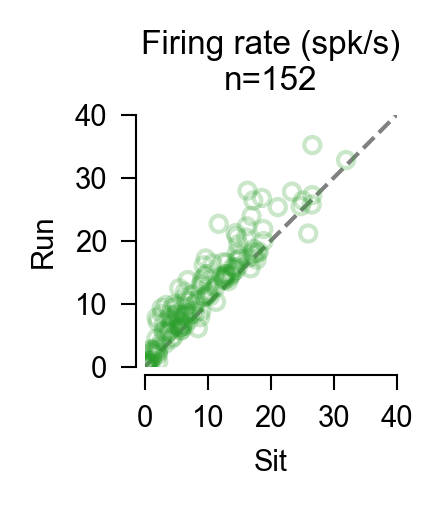

In [89]:
fig, ax = plot_fr_scatter(frs_sit, frs_run, labels=['Sit', 'Run'], color='tab:green',
                        logscale=False, axlims=[0, 40], axticks=[0.1,1,10,100], dpi=300,  size=15)
# plt.savefig('locomotion_fr_scatter.pdf')

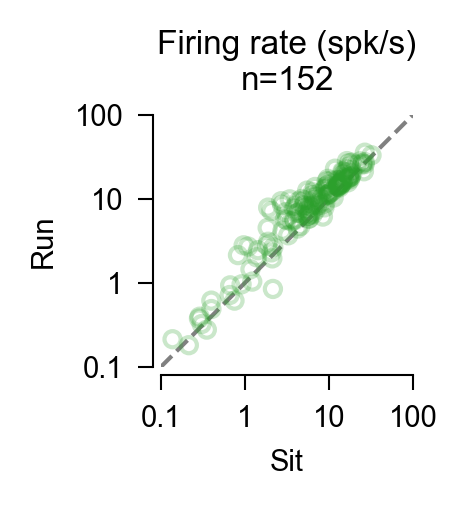

In [20]:
fig, ax = plot_fr_scatter(frs_sit, frs_run, labels=['Sit', 'Run'], color='tab:green',
                        logscale=True, axlims=[0.1, 100], axticks=[0.1,1,10,100], dpi=300,  size=15)
# plt.savefig('locomotion_fr_scatter.pdf')

## Stats tests

In [15]:
# Perform statistical significance test
# Given that we sample two values from each neuron (ctrl vs opto) and mean FRs in each condition will be dependent on the neuron
# (high FR neurons will likely have high FRs both in ctrl and opto), and given that FRs are likely not normally distributed (but log-normally),
# the Wilcoxon rank signed rank test seems most appropriate

print('Mean FRs sitting vs running:')

# Wilcoxon signed rank: non-parametric, paired samples
from scipy.stats import wilcoxon
print(wilcoxon(frs_sit, frs_run))

# Mann-Whitney U / Mann–Whitney–Wilcoxon (MWW) / Wilcoxon rank-sum test: non-parametric, independent samples
from scipy.stats import mannwhitneyu
print(mannwhitneyu(frs_sit, frs_run))#, alternative='less'))

# T-test rel: parametric, paired samples
from scipy.stats import ttest_rel
print(ttest_rel(frs_sit, frs_run))

# T-test ind: parametric, independent samples
from scipy.stats import ttest_ind
print(ttest_ind(frs_sit, frs_run))

Mean FRs sitting vs running:
WilcoxonResult(statistic=603.0, pvalue=9.211928668015359e-22)
MannwhitneyuResult(statistic=9464.0, pvalue=0.0032238123109175273)
Ttest_relResult(statistic=-10.888579609562369, pvalue=9.65333780810595e-21)
Ttest_indResult(statistic=-2.728985765732791, pvalue=0.006725426912989971)


## If stimcond='spont'

In [25]:
rmis = np.zeros((len(keys)))
frs_run = np.zeros((len(keys)))
frs_sit = np.zeros((len(keys)))
for i,key in enumerate(keys):
    rmi,frs_run[i],frs_sit[i] = get_rmi(key, stimcond='spont')
    rmis[i] = rmi

In [ ]:
rmis = np.zeros((len(keys)))
frs_run = np.zeros((len(keys)))
frs_sit = np.zeros((len(keys)))
for i,key in enumerate(keys):
    rmi,frs_run[i],frs_sit[i] = get_rmi(key)
    rmis[i] = rmi

In [30]:
rmis.shape

(156,)

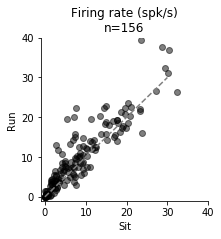

In [27]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(frs_sit, frs_run, color='k', alpha=0.5)
ax.plot([0,30], [0, 30], linestyle='--', color='gray')
ax.set_xlabel('Sit')
ax.set_ylabel('Run')
ax.set_ylim([-1, 40])
ax.set_xlim([-1, 40])
ax.set_title('Firing rate (spk/s)\nn={:d}'.format(len(keys)))
sns.despine()